In [162]:
%matplotlib inline
import requests
import gzip
import numpy as np
import pandas as pd
import patoolib
import matplotlib.pyplot as plt
import tensorflow as tf
import torch
import torch.nn as nn
from time import time
from sklearn import metrics
import torchvision.datasets as datasets
from torch.autograd import Variable
from torchvision.transforms import ToTensor
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.metrics import accuracy_score
from sklearn.metrics.cluster import adjusted_rand_score


In [163]:
DATASET_SIZE = 70000
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()


Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


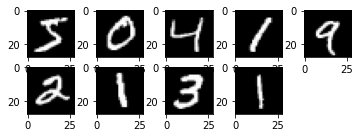

In [164]:
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))
for i in range(9):
    plt.subplot(4,5, 1 + i)
    plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
plt.show()

In [130]:
x_train = x_train.reshape((x_train.shape[0],28, 28, 1))
x_test = x_test.reshape((x_test.shape[0], 28, 28, 1))

In [131]:
x_train=x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [132]:
x_train /= 255
x_test /= 255

print("Train matrix shape", x_train.shape)
print("Test matrix shape", x_test.shape)

Train matrix shape (60000, 784)
Test matrix shape (10000, 784)


In [133]:
colors = ["#476A2A","#7851B8",'#BD3430','#4A2D4E','#875525',
          '#A83683','#4E655E','#853541','#3A3120','#535D8E', 'black']

In [134]:

scaler = StandardScaler()
trainX = scaler.fit_transform(x_train)
testX = scaler.fit_transform(x_test)
print(trainX.shape)
print(testX.shape)

(60000, 784)
(10000, 784)


In [135]:
t=time()

pca = PCA(n_components=784, random_state=0)
train_pca = pca.fit_transform(trainX, y_train)
test_pca = pca.fit_transform(testX, y_test)

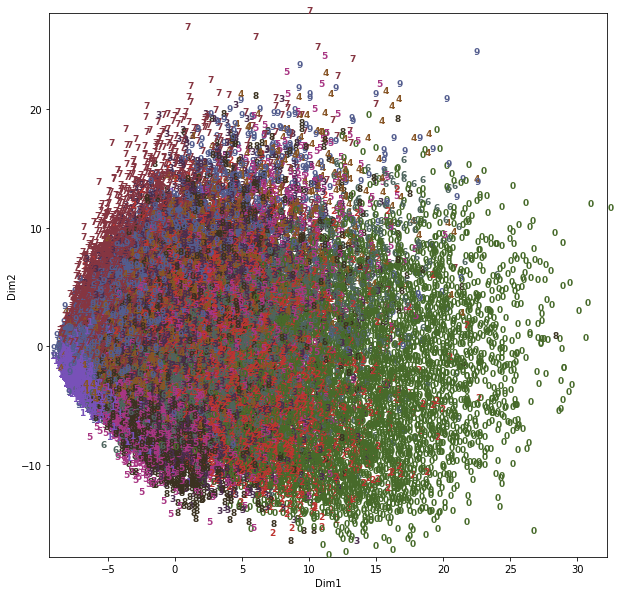

In [137]:
plt.figure(figsize=(10,10))
plt.xlim(train_pca[:,0].min(), train_pca[:,0].max())
plt.ylim(train_pca[:,1].min(), train_pca[:,1].max())
for i in range(len(trainX)):
    plt.text(train_pca[i,0], train_pca[i,1], str(y_train[i]),
             color = colors[y_train[i]],
            fontdict={'weight':'bold', 'size':9})
plt.xlabel("Dim1")
plt.ylabel("Dim2")
# plt.text(15, 25, str("PCA time: {}".format(time()-t)),
#          bbox = dict(boxstyle='round', facecolor='wheat', alpha=0.5),
#          fontsize=9)
plt.show()

In [161]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [138]:
km = KMeans(n_clusters=10, random_state=0)
km = km.fit(train_pca)
labels_km = km.labels_
clusters_km = km.predict(test_pca)

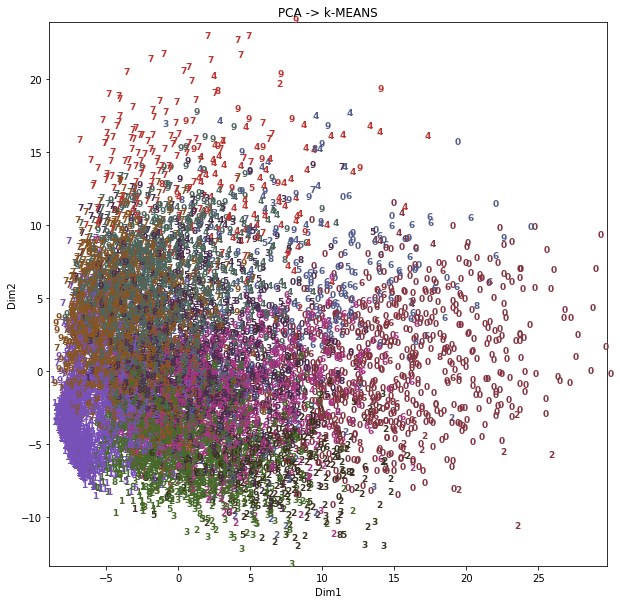

In [139]:
plt.figure(figsize=(10,10))
plt.xlim(test_pca[:,0].min(), test_pca[:,0].max())
plt.ylim(test_pca[:,1].min(), test_pca[:,1].max())
for i in range(len(y_test)):
    plt.text(test_pca[i,0], test_pca[i,1], str(y_test[i]),
             color = colors[clusters_km[i]],
             fontdict={'weight':'bold', 'size':9})
plt.title('PCA -> k-MEANS')
plt.xlabel("Dim1")
plt.ylabel("Dim2")
# plt.text(15, 25, str("k-MEANS time: {}".format(time()-t)),
#          bbox = dict(boxstyle='round', facecolor='wheat', alpha=0.5),
#          fontsize=9)
plt.show()

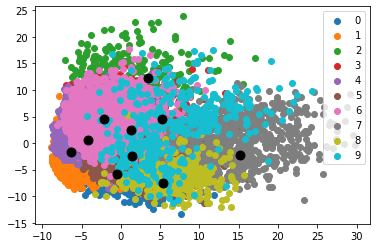

In [140]:
#Getting unique labels
 
u_labels = np.unique(clusters_km)
centroids = km.cluster_centers_
 
#plotting the results:
 
for i in u_labels:
    plt.scatter(test_pca[clusters_km == i , 0] , test_pca[clusters_km == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
plt.legend()
plt.show()

In [141]:
report_trainning=metrics.confusion_matrix(y_test, clusters_km) # due to batching we need to make this the input to confusion matrix
# sklearn.metrics.confusion_matrix
report_trainning
cm_df_trainning = pd.DataFrame(report_trainning,
                     index = ['0','1','2','3','4','5','6','7','8','9'], #,labels=["0", "1", "2","3", "4", "5","6", "7", "8","9"]
                     columns = ['0','1','2','3','4','5','6','7','8','9'])
cm_df_trainning

,0,1,2,3,4,5,6,7,8,9
0,19,13,0,140,11,50,33,622,63,29
1,72,1052,0,6,0,3,0,0,1,1
2,205,170,3,44,1,209,28,20,190,162
3,257,193,3,489,12,20,3,1,18,14
4,3,84,74,34,81,19,650,9,0,28
5,155,125,1,339,167,12,53,4,25,11
6,10,62,0,7,0,683,7,32,60,97
7,29,147,151,37,550,1,110,0,0,3
8,350,126,2,302,100,6,51,9,11,17
9,11,57,19,58,366,1,473,4,0,20


In [142]:
print ("Accuracy Score of Kmeans testing set: {:.2f}".format(accuracy_score(y_test, clusters_km)))
print ("ARI of Kmeans testing set: {:.2f}".format(adjusted_rand_score(y_test, clusters_km)))

Accuracy Score of Kmeans testing set: 0.17
ARI of Kmeans testing set: 0.28


In [143]:
km_5 = KMeans(n_clusters=5, random_state=0)
km_5 = km_5.fit(train_pca)
labels_km_5 = km_5.labels_
clusters_km_5 = km_5.predict(test_pca)

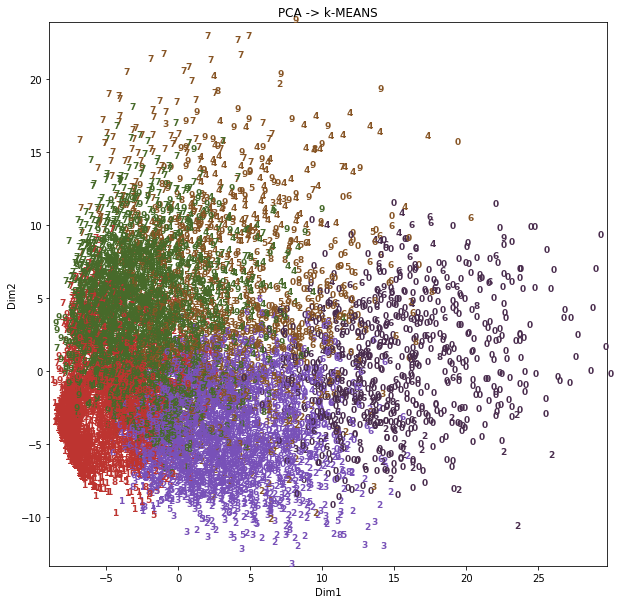

In [144]:
plt.figure(figsize=(10,10))
plt.xlim(test_pca[:,0].min(), test_pca[:,0].max())
plt.ylim(test_pca[:,1].min(), test_pca[:,1].max())
for i in range(len(y_test)):
    plt.text(test_pca[i,0], test_pca[i,1], str(y_test[i]),
             color = colors[clusters_km_5[i]],
             fontdict={'weight':'bold', 'size':9})
plt.title('PCA -> k-MEANS')
plt.xlabel("Dim1")
plt.ylabel("Dim2")
# plt.text(15, 25, str("k-MEANS time: {}".format(time()-t)),
#          bbox = dict(boxstyle='round', facecolor='wheat', alpha=0.5),
#          fontsize=9)
plt.show()

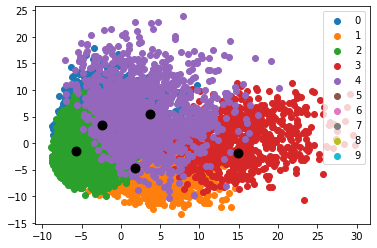

In [145]:
#Getting unique labels
 
u_labels_5 = np.unique(clusters_km_5)
centroids_5 = km_5.cluster_centers_
 
#plotting the results:
 
for i in u_labels:
    plt.scatter(test_pca[clusters_km_5 == i , 0] , test_pca[clusters_km_5 == i , 1] , label = i)
plt.scatter(centroids_5[:,0] , centroids_5[:,1] , s = 80, color = 'k')
plt.legend()
plt.show()

In [146]:
report_trainning=metrics.confusion_matrix(y_test, clusters_km_5) # due to batching we need to make this the input to confusion matrix
# sklearn.metrics.confusion_matrix
report_trainning
cm_df_trainning = pd.DataFrame(report_trainning,
                     index = ['0','1','2','3','4','5','6','7','8','9'], #,labels=["0", "1", "2","3", "4", "5","6", "7", "8","9"]
                     columns = ['0','1','2','3','4','5','6','7','8','9'])
cm_df_trainning

,0,1,2,3,4,5,6,7,8,9
0,14,268,17,614,67,0,0,0,0,0
1,0,17,1115,0,3,0,0,0,0,0
2,24,590,206,26,186,0,0,0,0,0
3,29,403,359,1,218,0,0,0,0,0
4,657,19,123,11,172,0,0,0,0,0
5,257,282,214,6,133,0,0,0,0,0
6,6,678,70,86,118,0,0,0,0,0
7,695,11,196,1,125,0,0,0,0,0
8,226,279,295,13,161,0,0,0,0,0
9,775,9,95,5,125,0,0,0,0,0


In [147]:
print ("Accuracy Score of Kmeans testing set: {:.2f}".format(accuracy_score(y_test, clusters_km_5)))
print ("ARI of Kmeans testing set: {:.2f}".format(adjusted_rand_score(y_test, clusters_km_5)))

Accuracy Score of Kmeans testing set: 0.04
ARI of Kmeans testing set: 0.19


In [148]:
# trainning and validation data
all_data=pd.read_csv('all.csv',index_col=False,header=None)
shuffled_data=all_data.sample(frac = 1)
# feature=pd.read_csv('features.csv',index_col=False,header=None)
# target=pd.read_csv('target.csv',index_col=False,header=None)
feature=shuffled_data.iloc[:, 0:784]
target=shuffled_data.iloc[:, 784]



### Reading values only for trainning data
feature_in=feature.values
target_in=target.values

# converting to tensor train data
feature_tensor=feature_in[0:2000]
target_tensor=target_in[0:2000]

# converting to tensor test data
feature_tensor_test=feature_in[2000:3000]
target_tensor_test=target_in[2000:3000]

In [149]:
t=time()

pca = PCA(n_components=784, random_state=0)
train_pca = pca.fit_transform(feature_tensor, target_tensor)
test_pca = pca.fit_transform(feature_tensor_test, target_tensor_test)

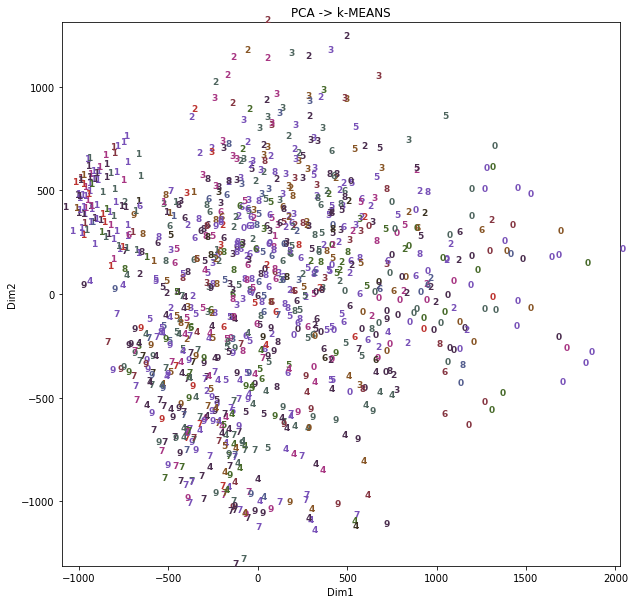

In [150]:
plt.figure(figsize=(10,10))
plt.xlim(test_pca[:,0].min(), test_pca[:,0].max())
plt.ylim(test_pca[:,1].min(), test_pca[:,1].max())
for i in range(len(target_tensor_test)):
    plt.text(test_pca[i,0], test_pca[i,1], str(target_tensor_test[i]),
             color = colors[clusters_km[i]],
             fontdict={'weight':'bold', 'size':9})
plt.title('PCA -> k-MEANS')
plt.xlabel("Dim1")
plt.ylabel("Dim2")
# plt.text(15, 25, str("k-MEANS time: {}".format(time()-t)),
#          bbox = dict(boxstyle='round', facecolor='wheat', alpha=0.5),
#          fontsize=9)
plt.show()

In [151]:
km = KMeans(n_clusters=10, random_state=0)
km = km.fit(train_pca)
labels_km = km.labels_
clusters_km = km.predict(test_pca)

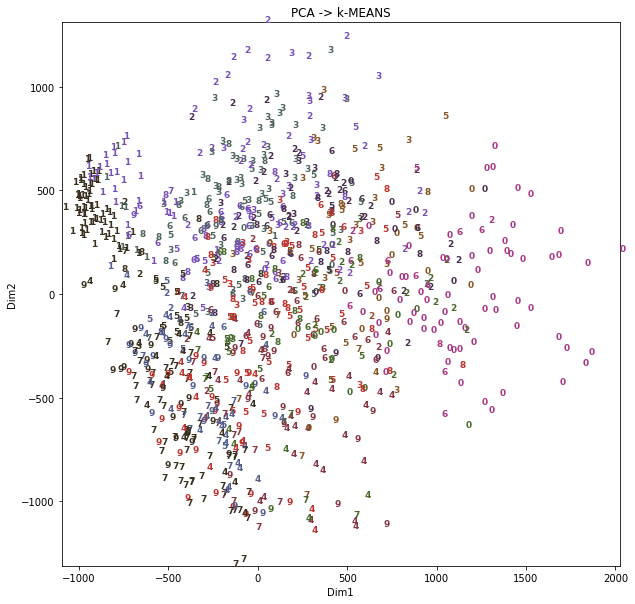

In [152]:
plt.figure(figsize=(10,10))
plt.xlim(test_pca[:,0].min(), test_pca[:,0].max())
plt.ylim(test_pca[:,1].min(), test_pca[:,1].max())
for i in range(len(target_tensor_test)):
    plt.text(test_pca[i,0], test_pca[i,1], str(target_tensor_test[i]),
             color = colors[clusters_km[i]],
             fontdict={'weight':'bold', 'size':9})
plt.title('PCA -> k-MEANS')
plt.xlabel("Dim1")
plt.ylabel("Dim2")
# plt.text(15, 25, str("k-MEANS time: {}".format(time()-t)),
#          bbox = dict(boxstyle='round', facecolor='wheat', alpha=0.5),
#          fontsize=9)
plt.show()

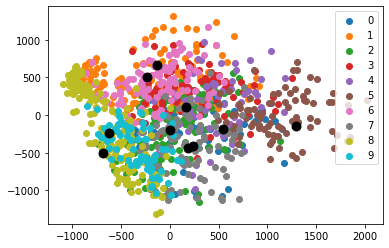

In [153]:
#Getting unique labels
 
u_labels = np.unique(clusters_km)
centroids = km.cluster_centers_
 
#plotting the results:
 
for i in u_labels:
    plt.scatter(test_pca[clusters_km == i , 0] , test_pca[clusters_km == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
plt.legend()
plt.show()

In [154]:
report_trainning=metrics.confusion_matrix(target_tensor_test, clusters_km) # due to batching we need to make this the input to confusion matrix
# sklearn.metrics.confusion_matrix
report_trainning
cm_df_trainning = pd.DataFrame(report_trainning,
                     index = ['0','1','2','3','4','5','6','7','8','9'], #,labels=["0", "1", "2","3", "4", "5","6", "7", "8","9"]
                     columns = ['0','1','2','3','4','5','6','7','8','9'])
cm_df_trainning

,0,1,2,3,4,5,6,7,8,9
0,12,1,0,8,10,66,3,2,0,0
1,0,30,0,0,0,0,10,0,66,1
2,20,38,0,39,1,2,1,5,2,3
3,4,14,9,6,18,0,44,1,2,1
4,7,1,16,0,1,0,0,31,16,30
5,11,8,28,2,14,1,18,2,15,6
6,5,25,3,13,0,10,9,23,0,4
7,7,1,0,1,6,0,2,12,59,9
8,12,13,25,15,2,1,16,2,6,1
9,2,1,25,3,4,0,1,16,20,20


In [155]:
print ("Accuracy Score of Kmeans testing set: {:.2f}".format(accuracy_score(target_tensor_test, clusters_km)))
print ("ARI of Kmeans testing set: {:.2f}".format(adjusted_rand_score(target_tensor_test, clusters_km)))

Accuracy Score of Kmeans testing set: 0.10
ARI of Kmeans testing set: 0.18


In [156]:
km_5 = KMeans(n_clusters=5, random_state=0)
km_5 = km_5.fit(train_pca)
labels_km_5 = km_5.labels_
clusters_km_5 = km_5.predict(test_pca)

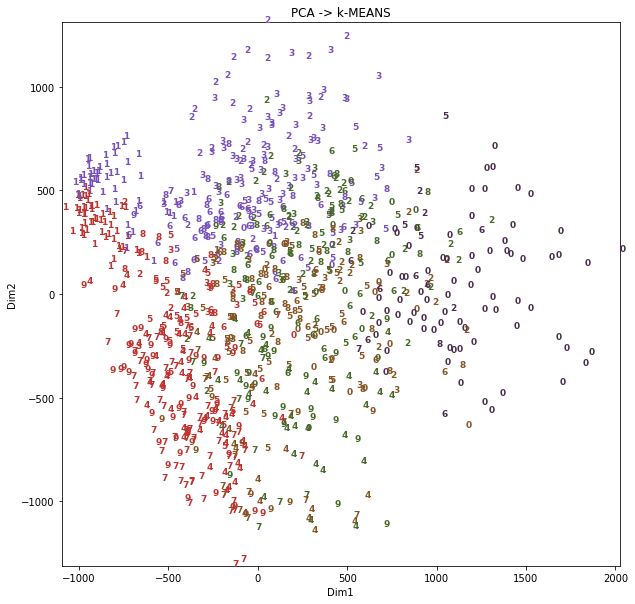

In [157]:
plt.figure(figsize=(10,10))
plt.xlim(test_pca[:,0].min(), test_pca[:,0].max())
plt.ylim(test_pca[:,1].min(), test_pca[:,1].max())
for i in range(len(target_tensor_test)):
    plt.text(test_pca[i,0], test_pca[i,1], str(target_tensor_test[i]),
             color = colors[clusters_km_5[i]],
             fontdict={'weight':'bold', 'size':9})
plt.title('PCA -> k-MEANS')
plt.xlabel("Dim1")
plt.ylabel("Dim2")
# plt.text(15, 25, str("k-MEANS time: {}".format(time()-t)),
#          bbox = dict(boxstyle='round', facecolor='wheat', alpha=0.5),
#          fontsize=9)
plt.show()

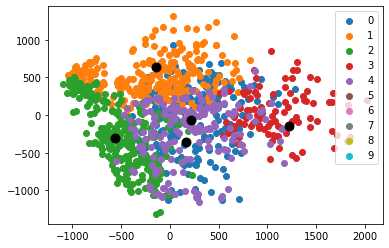

In [158]:
#Getting unique labels
 
u_labels_5 = np.unique(clusters_km_5)
centroids_5 = km_5.cluster_centers_
 
#plotting the results:
 
for i in u_labels:
    plt.scatter(test_pca[clusters_km_5 == i , 0] , test_pca[clusters_km_5 == i , 1] , label = i)
plt.scatter(centroids_5[:,0] , centroids_5[:,1] , s = 80, color = 'k')
plt.legend()
plt.show()

In [159]:
report_trainning=metrics.confusion_matrix(target_tensor_test, clusters_km_5) # due to batching we need to make this the input to confusion matrix
# sklearn.metrics.confusion_matrix
report_trainning
cm_df_trainning = pd.DataFrame(report_trainning,
                     index = ['0','1','2','3','4','5','6','7','8','9'], #,labels=["0", "1", "2","3", "4", "5","6", "7", "8","9"]
                     columns = ['0','1','2','3','4','5','6','7','8','9'])
cm_df_trainning

,0,1,2,3,4,5,6,7,8,9
0,8,3,1,76,14,0,0,0,0,0
1,0,53,53,0,1,0,0,0,0,0
2,46,31,5,4,25,0,0,0,0,0
3,13,66,6,0,14,0,0,0,0,0
4,32,1,52,0,17,0,0,0,0,0
5,13,24,25,4,39,0,0,0,0,0
6,30,33,7,7,15,0,0,0,0,0
7,10,1,71,1,14,0,0,0,0,0
8,20,27,11,1,34,0,0,0,0,0
9,27,1,51,0,13,0,0,0,0,0


In [160]:
print ("Accuracy Score of Kmeans testing set: {:.2f}".format(accuracy_score(target_tensor_test, clusters_km_5)))
print ("ARI of Kmeans testing set: {:.2f}".format(adjusted_rand_score(target_tensor_test, clusters_km_5)))

Accuracy Score of Kmeans testing set: 0.08
ARI of Kmeans testing set: 0.13
